# Gender norms in home production and labor market supply


Our model project is **motivated** by a model from the study “Are Marriage-Related Taxes and Social Security Benefits Holding Back Female Labor Supply?” by Borella et al. (forthcoming). We are solving and simulating a $T$-period labor supply model with two-earner couples, where $M$ symbols a male and $F$ a female. For simplicity we assume that couples cannot divorce nor save. Individuals can either choose to spend time on home production or working in the labor market. The goal is to examine the labor supply in home- and market production given different levels of human capital and based on the presence of children.

We build on code provided by Thomas Jørgensen (2023) for the Household of the Life Cycle course lecture 6. See github repository: 
https://github.com/ThomasHJorgensen/HouseholdBehaviorCourse/tree/main 

The **Bellman equation** and the recursive formulation of our simple model is: 
$$
\begin{align*}
V_{t}(K_{M,t},K_{F,t}) & =\max_{T_{M,t},T_{F,t}}U(Q_{t},{T_{M,t},T_{F,t}})+\beta V_{t+1}(K_{M,t+1},K_{F,t+1})\\
\end{align*}
$$

**Total time** for individual $j$ can be spent on working at home $H_{t,j}$ or working in the market $L_{t,j}$
$$
T_{t}=L_{M,t}+H_{M,t}+L_{F,t}+H_{F,t}
$$

**Children** arrive stochastically:
$$
\begin{align*}
p(n_t)=&\begin{cases}
\begin{array}{ll}
p_n & \text{if } n_{t}=0\\
0 &  \text{if } n_{t}=1.
\end{array}\end{cases}
\end{align*}
$$

We simplify the model such that individuals can only have on child. 

Dis-utility of work, both in the household and on the labor market, depend on the presence of children:
$$
\rho^{1}_{M,F}(n_t) = \rho_{M,F} + \rho_{M,F} \cdot n_t 
$$

There is also an extra amount of dis-utility from labor market work in the presence of children:
$$
\rho^{2}_{M,F}(n_t) 
$$

Households maximize **utility** based on the following utility function: 
$$
U(Q_{t},T_{M,t},T_{F,t})=2\frac{(Q_{t}/2)^{1-\eta}}{1-\eta}-[\rho^{1}_{M}(n_{t})\frac{T_{M,t}^{1+\gamma}}{1+\gamma}+\rho^{1}_{F}(n_{t})\frac{T_{F,t}^{1+\gamma}}{1+\gamma}] - [\rho^{2}_{M}(n_{t})L_{M,t}^{\kappa} + \rho^{2}_{F}(n_{t})L_{F,t}^{\kappa} ]
$$

**Total consumption** is split on the household level where $\omega$ is the weight on market goods
$$
Q_{t}=C_{t}^{\omega}H_{t}^{1-\omega}
$$
**Consumption** of home productivity is determined by the elasticity of substitution $\sigma$
$$
\begin{align*}
H_{t} & =\begin{cases}
\min\{H_{M,t},H_{F,t}\} & \text{if }\sigma=0\\
H_{M,t}^{1-\alpha}H_{F,t}^{\alpha} & \text{if }\sigma=1\\
\left((1-\alpha)H_{M,t}^{\frac{\sigma-1}{\sigma}}+\alpha H_{F,t}^{\frac{\sigma-1}{\sigma}}\right)^{\frac{\sigma}{\sigma-1}} & \text{else}
\end{cases}\\
\end{align*}
$$
Where the relative productivity level in home production for females relative to men is given by ${\frac{\alpha}{1-\alpha}}$

**Consumption** of market goods are determined by
$$
\begin{align*}
C_{t} & = w_{M,t}L_{M,t} + w_{F,t}L_{F,t}
\end{align*}
$$

Where the **wages** are endogenous and increase with amount of human capital: 
$$
\begin{align*}
\log w_{j,t} & =\kappa_{j,0}+\kappa_{j,1}K_{j,t},\;j\in\{M,F\}\\
\end{align*}
$$

**Human capital** is also endogenous and increases with labor supply: 
$$
\begin{align*}
K_{j,t+1} & =(1-\delta_{1})K_{j,t}+L_{j,t},\;j\in\{M,F\}\\
\end{align*}
$$

Where $\delta_{1}$ is the depreciation rate in the level of human capital. 


**Terminal period ($T$):** There are no bequests such that all market consumption is spent in last period
$$
V_{T}(K_{M,T},K_{F,T})  =\max_{T_{M,T},T_{F,T}} U(Q_{T},{T_{M,T},T_{F,T}})
$$


## 2. Optimization by interpolation
We solve this dynamic model numerically by **2-dimensional interpolation** from "consav.linear_interp" from **scipy**. 

The overall concept of linear interpolation is that we have a point, x, that are not in our known grid vector and we therefore do not have any value for. In order to obtain the value for x, we interpolate via alreade known points in our grid. 
 
At first, we find `t` such that x is in between two known grid values: 
$$
K_{t} \leq x < K_{t+1}
$$

Once we know `t`, we compute the interpolated value by the value function and the grid vector: 

$$
y =  V_{t} + \frac{V_{t+1}-V_{t}}{K_{t+1}-K_{i}}(x-K_{t})
$$


The following is an example of how a one dimensional interpolation works based on a given human capital grid $(K)$, some known output values of the value function ($V$) and some unknown points ($x$) we need to interpolate: 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

x =  2.0 -> true =    1.4, interpolated =    1.4
x =  4.0 -> true =    2.0, interpolated =    2.0
x =  7.0 -> true =    2.6, interpolated =    2.6
x =  9.0 -> true =    3.0, interpolated =    3.0


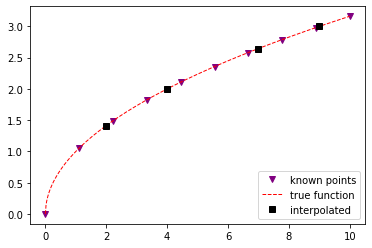

In [2]:
def linear_interpolate(K,V,x):
    """ linear interpolation (and extrapolation)
    
    Args:
        K (np.ndarray): human capital, known points
        V (np.ndarray): value function, known values
        x (float): point to be interpolated
        
    Returns:
        y (float): interpolated value
    
    """
    
    assert len(K) == len(V)
    n = len(K)
    
    # a. find time in known points
    if x < K[1]: # extrapolation below
        t = 0
    
    elif x > K[-2]: # extrapolation above
        t = n-2

    else: # the true interpolation
        # search
        t = 0 
        while x >= K[t+1] and t < n-1:
            t += 1
        
        # check
        assert x >= K[t]
        assert x < K[t+1]

    # b. interpolate
    diff_K = K[t+1]-K[t]
    diff_V = V[t+1]-V[t]
    slope = diff_V/diff_K
    y = V[t] + slope*(x-K[t])
    
    return y


f = lambda x: (x)**0.5

K = np.linspace(0,10,10)
V = f(K)

grid = np.linspace(0,10,500) 
V_true = f(grid)


# interpolate
X = [2,4,7,9]
V_approx = []
for x in X:
    true = f(x)
    y = linear_interpolate(K,V,x)
    V_approx.append(y)
    print(f'x = {x:4.1f} -> true = {true:6.1f}, interpolated = {y:6.1f}')

# plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(K,V,'v',label='known points', color= 'purple')
ax.plot(grid,V_true,'--',lw=1,label='true function', color= 'red')
ax.plot(X,V_approx,'s',lw=1,label='interpolated', color= 'black')
ax.legend(loc='lower right',facecolor='white',frameon=True);


## 3. Interpolation in our model
Our goal is to solve the value function for each period and the associated optimal hours worked in home production and labor market for a given human capital level $K$. As we do have a dynamic, intertemporal model, the interpolation is a bit more complex than the above example with a one dimensionel interpolation. 

In order to solve the model for all periods, we **first** solve the value function for the terminal period for a given human kapital $V_{T}(K_{1,T},K_{2,T})$. **Next**, we construct the interpolator of the value function by "interp_2d()" that interpolates a 2-dimensional function using linear interpolation on a rectangular human capital grid. **Finally**, we use the interpolator to solve the model by backwards induction for each period and find the optimal hours worked in home production and in labor market for some given parameter values. 

## 4. Numerical solution

In [3]:
# loading local model file and initializing model class
from modelproject import DynHouseholdLaborModelClass
model = DynHouseholdLaborModelClass()

par = model.par
sol = model.sol
sim = model.sim


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
model.solve()

/Users/bruger/Desktop/projects-2023-aca/modelproject/modelproject.py:250: RuntimeWarning: divide by zero encountered in double_scalars
  util_1 = ((Q/2))**(1.0-par.eta) / (1.0-par.eta) - rho1*(total1)**(1.0+par.gamma) / (1.0+par.gamma) - par.rho_21*kids*par.norms*labor1**par.kappa
/Users/bruger/Desktop/projects-2023-aca/modelproject/modelproject.py:251: RuntimeWarning: divide by zero encountered in double_scalars
  util_2 = ((Q/2))**(1.0-par.eta) / (1.0-par.eta) - rho2*(total2)**(1.0+par.gamma) / (1.0+par.gamma) - par.rho_22*kids*labor2**par.kappa


### Simulation

Now that we have a solution for all combinations of human capital grid points, we simulate `simN` synthetic individuals for `simT` periods. We do this by initializing all state-variables in the first period and simulate forwards. 

The state variables in our model include children and initial human capital of both member.  <br>

We then loop forward using the solution:
$$
\begin{align*}
L_{M,i,t} &= L_{M,t}^{\star}(K_{M,i,t},K_{F,i,t}) \\
H_{M,i,t} &= H_{M,t}^{\star}(K_{M,i,t},K_{F,i,t}) \\
L_{F,i,t} &= L_{F,t}^{\star}(K_{M,i,t},k_{F,i,t}) \\
H_{F,i,t} &= H_{F,t}^{\star}(K_{M,i,t},K_{F,i,t}) \\
K_{M,i,t+1} &= (1-\delta)K_{M,i,t} + L_{M,i,t}\\
K_{F,i,t+1} &= (1-\delta)K_{F,i,t} + L_{F,i,t}\\
n_{i,t+1} &= n_{i,t} + b_{i,t}\\
\end{align*}
$$



### 4.1: Baseline model 
In the baseline model, we initialize male and female with no human capital `sim.k1_init=np.zeros(par.simN)` and  `sim.k2_init=np.zeros(par.simN)`. $\alpha=0.5$ such that male and female agents are equally productive at housework. $\sigma=1$ such that production of male and female housework only depends on their relative productivity - namely captured by $\alpha$. In addition, men and women get the same amount of disutility from working after having children.

In [5]:
model1 = model.copy()

In [6]:
model1.simulate()

In [7]:
# Male to female ratio of labor hours and home production
rel_l = np.round(np.mean(getattr(model1.sim,'l2'),axis=0) / np.mean(getattr(model1.sim,'l1'),axis=0), 1)
rel_h = np.round(np.mean(getattr(model1.sim,'h2'),axis=0) / np.mean(getattr(model1.sim,'h1'),axis=0), 1)
rel_in = np.round(np.mean(getattr(model1.sim,'income2'),axis=0) / np.mean(getattr(model1.sim,'income1'),axis=0), 1)

# Total labor hours and home production
total_l = np.mean(getattr(model1.sim,'l1') + getattr(model1.sim,'l2'),axis=0)
total_h = np.mean(getattr(model1.sim,'h1') + getattr(model1.sim,'h2'),axis=0)

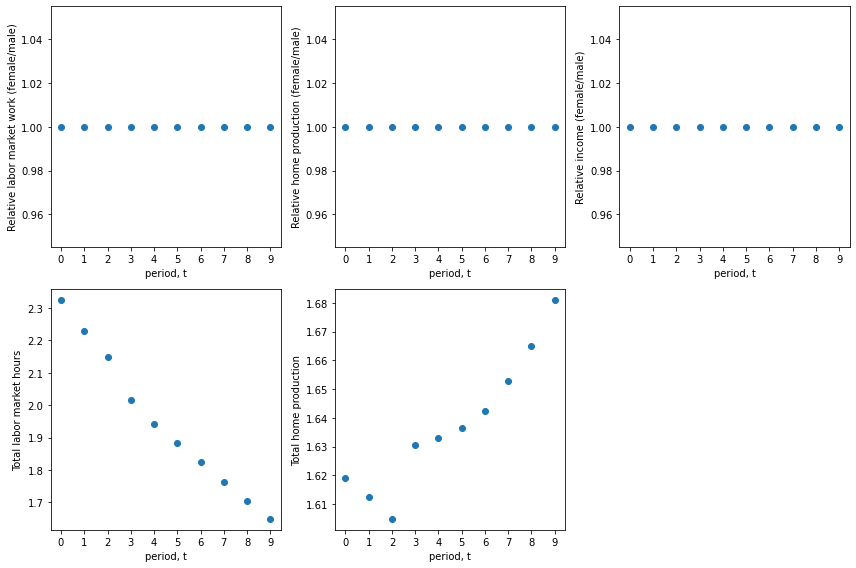

In [8]:
import matplotlib.pyplot as plt

# create figure with subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# plot first graph on first subplot
axs[0, 0].scatter(range(par.simT), rel_l, label='Simulated')
axs[0, 0].set(xlabel='period, t', ylabel='Relative labor market work (female/male)',
              xticks=range(par.simT))

# plot second graph on second subplot
axs[0, 1].scatter(range(par.simT), rel_h, label='Simulated')
axs[0, 1].set(xlabel='period, t', ylabel='Relative home production (female/male)',
              xticks=range(par.simT))

# plot third graph on third subplot
axs[0, 2].scatter(range(par.simT), rel_in, label='Simulated')
axs[0, 2].set(xlabel='period, t', ylabel='Relative income (female/male)',
              xticks=range(par.simT))

# plot fourth graph on fourth subplot
axs[1, 0].scatter(range(par.simT), total_l, label='Simulated')
axs[1, 0].set(xlabel='period, t', ylabel='Total labor market hours',
              xticks=range(par.simT))

# plot fifth graph on fifth subplot
axs[1, 1].scatter(range(par.simT), total_h, label='Simulated')
axs[1, 1].set(xlabel='period, t', ylabel='Total home production',
              xticks=range(par.simT))

# remove sixth subplot
fig.delaxes(axs[1, 2])

# adjust layout and spacing
fig.tight_layout()

# display the figure
plt.show()


When men and women are initiated with the same level of human capital and have the same preferences for consumption and house production, they work an equal amount of hours in the labor market and in the home production. Their incomes are therefore also the same. House production starts to increase after period 2, which represents the extra amount of disutility the household get from working in the labor market after having children. 

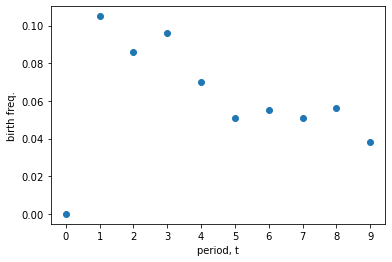

In [9]:
# birth
birth = np.zeros(model1.sim.n.shape,dtype=np.int_)
birth[:,1:] = (model1.sim.n[:,1:] - model1.sim.n[:,:-1]) > 0
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(range(model1.par.simT),np.mean(birth,axis=0))
ax.set(xlabel='period, t',ylabel=f'birth freq.',xticks=range(model1.par.simT));

The above figure is based on a probability of 10 pct. that a child arrives each period and that agents are only having one child. The figure above shows average number of children pr. period. Agents cannot have any children before period 1. Afterwards, average number of births per period decrease - namely because they can only have one child over the life cycle. 

In [10]:
# time since birth
periods = np.tile([t for t in range(model1.par.simT)],(model.par.simN,1))
time_of_birth = np.max(periods * birth, axis=1)

I = time_of_birth>0
time_of_birth[~I] = -1000 # never as a child
time_of_birth = np.transpose(np.tile(time_of_birth , (model1.par.simT,1)))

time_since_birth = periods - time_of_birth

In [11]:
# calculate average outcome across time since birth
min_time = -8
max_time = 8
event_grid = np.arange(min_time,max_time+1)

In [12]:
event_hours_l_1 = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_l_1[t] = np.mean(model1.sim.l1[time_since_birth==time])

event_hours_l_2 = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_l_2[t] = np.mean(model1.sim.l2[time_since_birth==time])

# relative to period before birth
event_hours_rel_l_1 = event_hours_l_1 - event_hours_l_1[event_grid==-1]
event_hours_rel_l_2 = event_hours_l_2 - event_hours_l_2[event_grid==-1]

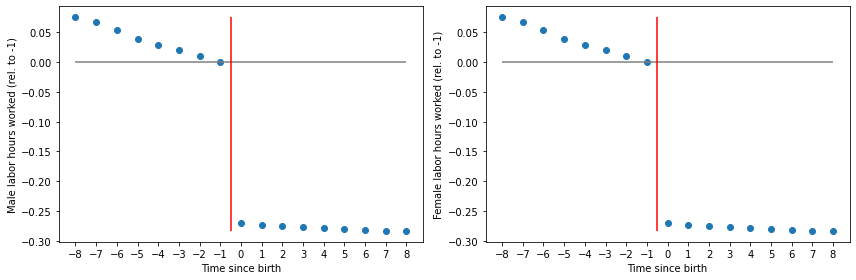

In [13]:
#Plotting figures for hours worked in market relative periods before birth
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter(event_grid, event_hours_rel_l_1)
axs[0].hlines(y=0, xmin=event_grid[0], xmax=event_grid[-1], color='gray')
axs[0].vlines(x=-0.5, ymin=np.nanmin(event_hours_rel_l_1), ymax=np.nanmax(event_hours_rel_l_1), color='red')
axs[0].set(xlabel='Time since birth', ylabel=f'Male labor hours worked (rel. to -1)', xticks=event_grid)

axs[1].scatter(event_grid, event_hours_rel_l_2)
axs[1].hlines(y=0, xmin=event_grid[0], xmax=event_grid[-1], color='gray')
axs[1].vlines(x=-0.5, ymin=np.nanmin(event_hours_rel_l_2), ymax=np.nanmax(event_hours_rel_l_2), color='red')
axs[1].set(xlabel='Time since birth', ylabel=f'Female labor hours worked (rel. to -1)', xticks=event_grid)

plt.tight_layout()


In [14]:
event_hours_h_1 = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_h_1[t] = np.mean(model1.sim.h1[time_since_birth==time])

event_hours_h_2 = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_h_2[t] = np.mean(model1.sim.h2[time_since_birth==time])

# relative to period before birth
event_hours_rel_h_1 = event_hours_h_1 - event_hours_h_1[event_grid==-1]
event_hours_rel_h_2 = event_hours_h_2 - event_hours_h_2[event_grid==-1]

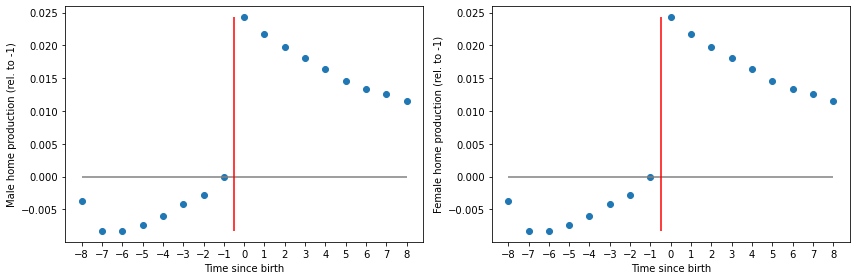

In [15]:
# Plotting figures for home production for relative periods before birth 
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter(event_grid, event_hours_rel_h_1)
axs[0].hlines(y=0, xmin=event_grid[0], xmax=event_grid[-1], color='gray')
axs[0].vlines(x=-0.5, ymin=np.nanmin(event_hours_rel_h_1), ymax=np.nanmax(event_hours_rel_h_1), color='red')
axs[0].set(xlabel='Time since birth', ylabel=f'Male home production (rel. to -1)', xticks=event_grid)

axs[1].scatter(event_grid, event_hours_rel_h_2)
axs[1].hlines(y=0, xmin=event_grid[0], xmax=event_grid[-1], color='gray')
axs[1].vlines(x=-0.5, ymin=np.nanmin(event_hours_rel_h_2), ymax=np.nanmax(event_hours_rel_h_2), color='red')
axs[1].set(xlabel='Time since birth', ylabel=f'Female home production (rel. to -1)', xticks=event_grid)

plt.tight_layout()


In time leading up to a birth, both men and women are decreasing their labor supply. This is because the income effect is dominating - because wages are endogenous and agents earn more income each period because they accumulate human capital. This in turn induces them to reduce their labor supply through the income effect. After having a child, both men and women decrease their labor supply an equal amount. This is because they get equal amount of extra disutility from working when having children. 

In the time up to a birth, both men and women are increasing their hours spent in the home and thereby home production. The reason is that as wages go up, agents can work less and still satisfy the same amount of consumption and at the same time achieve more utility from home production. When children arrive, both men and women increase home production.

In [16]:
event_i_1 = np.nan + np.zeros(event_grid.size)
for t, time in enumerate(event_grid):
    event_i_1[t] = np.mean(model1.sim.income1[time_since_birth==time])

event_i_2 = np.nan + np.zeros(event_grid.size)
for t, time in enumerate(event_grid):
    event_i_2[t] = np.mean(model1.sim.income2[time_since_birth==time])

# relative to period before birth
event_rel_i_1 = event_i_1 - event_i_1[event_grid==-1]
event_rel_i_2 = event_i_2 - event_i_2[event_grid==-1]

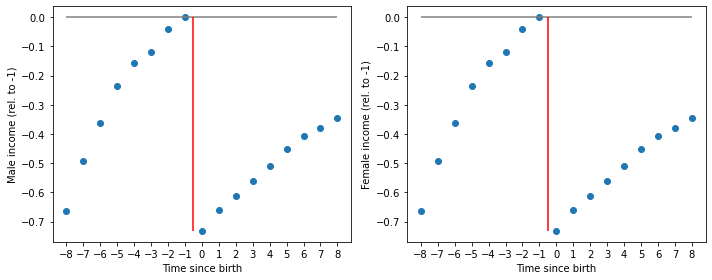

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# plot income relative to period before birth for male and female
ax1.scatter(event_grid, event_rel_i_1)
ax1.hlines(y=0, xmin=event_grid[0], xmax=event_grid[-1], color='gray')
ax1.vlines(x=-0.5, ymin=np.nanmin(event_rel_i_1), ymax=np.nanmax(event_rel_i_1), color='red')
ax1.set(xlabel='Time since birth', ylabel=f'Male income (rel. to -1)', xticks=event_grid)

ax2.scatter(event_grid, event_rel_i_2)
ax2.hlines(y=0, xmin=event_grid[0], xmax=event_grid[-1], color='gray')
ax2.vlines(x=-0.5, ymin=np.nanmin(event_rel_i_2), ymax=np.nanmax(event_rel_i_2), color='red')
ax2.set(xlabel='Time since birth', ylabel=f'Female income (rel. to -1)', xticks=event_grid)

plt.tight_layout()
plt.show()


All of the above mechanisms results in lower income for both men and women around the time of birth of their child. 

### 4.2: Different levels of initial human capital 

In [18]:
model2 = model.copy()

In [19]:
# Initializing the male with 8 human capital
model2.sim.k1_init = 8*np.ones(par.simN)
model2.simulate()

In [20]:
# Male to female ratio of labor hours and home production
rel_l = np.round(np.mean(getattr(model2.sim,'l2'),axis=0) / np.mean(getattr(model2.sim,'l1'),axis=0), 1)
rel_h = np.round(np.mean(getattr(model2.sim,'h2'),axis=0) / np.mean(getattr(model2.sim,'h1'),axis=0), 1)
rel_in = np.round(np.mean(getattr(model2.sim,'income2'),axis=0) / np.mean(getattr(model2.sim,'income1'),axis=0), 1)

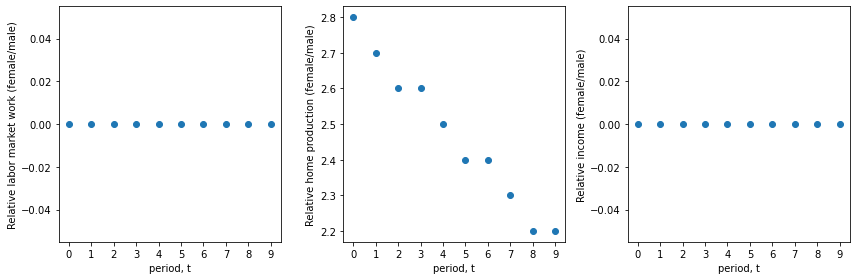

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].scatter(range(par.simT),rel_l,label='Simulated')
axs[0].set(xlabel='period, t',ylabel='Relative labor market work (female/male)',xticks=range(par.simT))

axs[1].scatter(range(par.simT),rel_h,label='Simulated')
axs[1].set(xlabel='period, t',ylabel='Relative home production (female/male)',xticks=range(par.simT))

axs[2].scatter(range(par.simT),rel_in,label='Simulated')
axs[2].set(xlabel='period, t',ylabel='Relative income (female/male)',xticks=range(par.simT))

fig.tight_layout()


When the male agent is intialized with a substantial amount of human capital, they will dedicate all of their time for labor market work whereas the female agents will dedicate all of their time to home production. In such a model, the child penalty (costs of having children) is non-relevant as the women is already away from the labor market before having children. 

### 4.3: Incorperating unequal norms

We try to mirror the evidence of the child penalties from Kleven et. al (2019) by incorperating unequal gender norms in household decisions in regards to children. 

We do this by defining a parameter par.norms, which is set to 1 in our baseline model and to 0 in this new model. 

When par.norms = 0, men do not get any extra disutility from working after having children. Mathematically, this implies that dis-utility of work depend on the presence of children:
$$
\rho_{M}(n_t) = \rho_{M}
$$

In [22]:
model3 = model.copy(par={'norms': 0.})

In [23]:
model3.solve()

In [24]:
model3.simulate()

In [25]:
# Male to female ratio of labor hours and home production
rel_l = np.round(np.mean(getattr(model3.sim,'l2'),axis=0) / np.mean(getattr(model3.sim,'l1'),axis=0), 3)
rel_h = np.round(np.mean(getattr(model3.sim,'h2'),axis=0) / np.mean(getattr(model3.sim,'h1'),axis=0), 3)
rel_in = np.round(np.mean(getattr(model3.sim,'income2'),axis=0) / np.mean(getattr(model3.sim,'income1'),axis=0), 3)

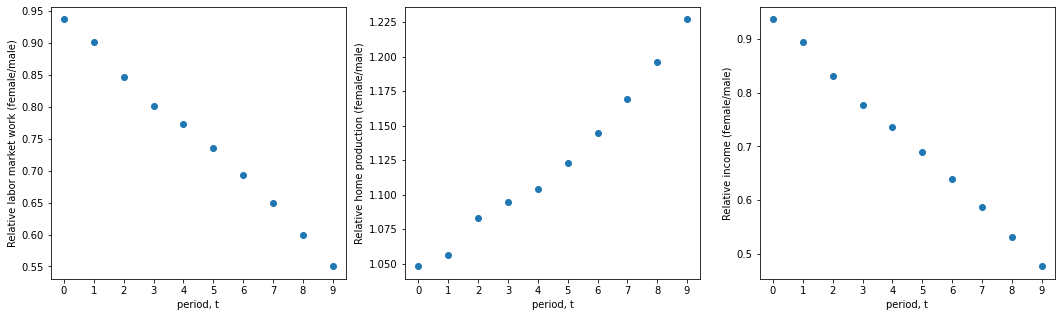

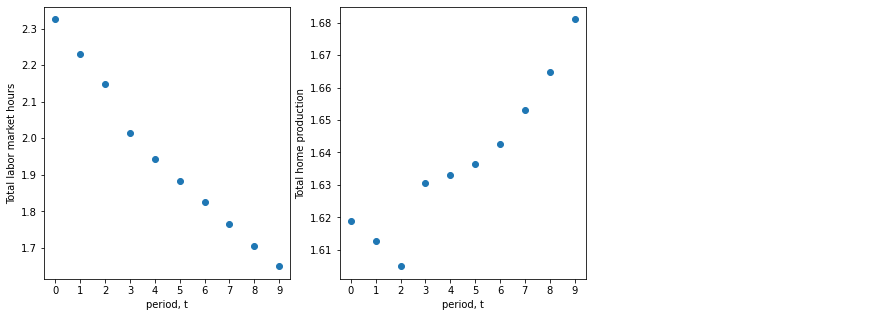

In [26]:
# First row of three figures
fig, axs = plt.subplots(ncols=3, figsize=(18, 5))
axs[0].scatter(range(par.simT),rel_l,label='Simulated')
axs[0].set(xlabel='period, t',ylabel='Relative labor market work (female/male)',xticks=range(par.simT))

axs[1].scatter(range(par.simT),rel_h,label='Simulated')
axs[1].set(xlabel='period, t',ylabel='Relative home production (female/male)',xticks=range(par.simT))

axs[2].scatter(range(par.simT),rel_in,label='Simulated')
axs[2].set(xlabel='period, t',ylabel='Relative income (female/male)',xticks=range(par.simT))

# Second row of three figures
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
axs[0].scatter(range(par.simT),total_l,label='Simulated')
axs[0].set(xlabel='period, t',ylabel='Total labor market hours',xticks=range(par.simT))

axs[1].scatter(range(par.simT),total_h,label='Simulated')
axs[1].set(xlabel='period, t',ylabel='Total home production',xticks=range(par.simT))

# Leave the middle axis empty for spacing purposes
axs[2].axis('off')

plt.show()


Females reduce their labor market supply over the life cycle relative to their husbands and increase home production in the new model. This leads to a fall in relative income. The effects are entirely driven by the norm effects described above as initial human capital and household productivity are the same.

In [27]:
# time since birth
periods = np.tile([t for t in range(model3.par.simT)],(model.par.simN,1))
time_of_birth = np.max(periods * birth, axis=1)

I = time_of_birth>0
time_of_birth[~I] = -1000 # never as a child
time_of_birth = np.transpose(np.tile(time_of_birth , (model3.par.simT,1)))

time_since_birth = periods - time_of_birth

In [28]:
# calculate average outcome across time since birth
min_time = -8
max_time = 8
event_grid = np.arange(min_time,max_time+1)

In [29]:
event_hours_l_1_n = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_l_1_n[t] = np.mean(model3.sim.l1[time_since_birth==time])

event_hours_l_2_n = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_l_2_n[t] = np.mean(model3.sim.l2[time_since_birth==time])

# relative to period before birth
event_hours_rel_l_1_n = event_hours_l_1_n - event_hours_l_1_n[event_grid==-1]
event_hours_rel_l_2_n = event_hours_l_2_n - event_hours_l_2_n[event_grid==-1]

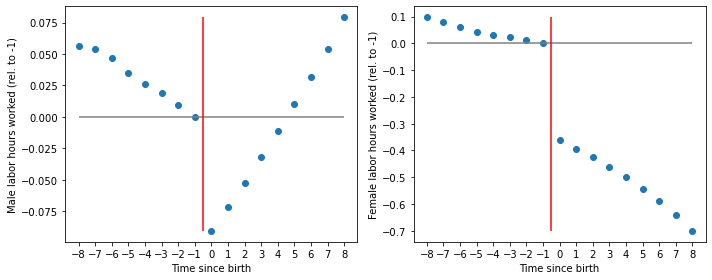

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter(event_grid, event_hours_rel_l_1_n)
ax1.hlines(y=0, xmin=event_grid[0], xmax=event_grid[-1], color='gray')
ax1.vlines(x=-0.5, ymin=np.nanmin(event_hours_rel_l_1_n), ymax=np.nanmax(event_hours_rel_l_1_n), color='red')
ax1.set(xlabel='Time since birth', ylabel=f'Male labor hours worked (rel. to -1)', xticks=event_grid)

ax2.scatter(event_grid, event_hours_rel_l_2_n)
ax2.hlines(y=0, xmin=event_grid[0], xmax=event_grid[-1], color='gray')
ax2.vlines(x=-0.5, ymin=np.nanmin(event_hours_rel_l_2_n), ymax=np.nanmax(event_hours_rel_l_2_n), color='red')
ax2.set(xlabel='Time since birth', ylabel=f'Female labor hours worked (rel. to -1)', xticks=event_grid)

fig.tight_layout()
plt.show()


In the time up to having a child, both men and women reduce their labor market supply due to the income effect. At the time of birth, there is a large drop in female labor supply which continues to decrease through the life cycle. Men also reduce their labor supply but increase it again in all periods after birth. 

In [31]:
event_hours_h_1_n = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_h_1_n[t] = np.mean(model3.sim.h1[time_since_birth==time])

event_hours_h_2_n = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_h_2_n[t] = np.mean(model3.sim.h2[time_since_birth==time])

# relative to period before birth
event_hours_rel_h_1_n = event_hours_h_1_n - event_hours_h_1_n[event_grid==-1]
event_hours_rel_h_2_n = event_hours_h_2_n - event_hours_h_2_n[event_grid==-1]

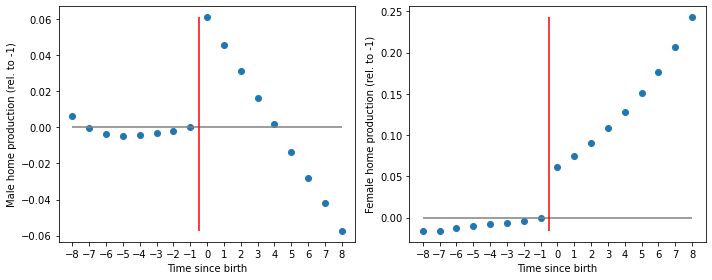

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.scatter(event_grid,event_hours_rel_h_1_n)
ax1.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax1.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel_h_1_n),ymax=np.nanmax(event_hours_rel_h_1_n),color='red')
ax1.set(xlabel='Time since birth',ylabel=f'Male home production (rel. to -1)',xticks=event_grid);

ax2.scatter(event_grid,event_hours_rel_h_2_n)
ax2.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax2.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel_h_2_n),ymax=np.nanmax(event_hours_rel_h_2_n),color='red')
ax2.set(xlabel='Time since birth',ylabel=f'Female home production (rel. to -1)',xticks=event_grid);

plt.tight_layout()


After having children, females' return to human capital decrease, making it more productive for her to work in the home. As  the home production function is cobb dogulas $H=H_{M}^{1-\alpha}H_{F}^{\alpha}$, there is increasing returns to male home production - i.e. the FOC is $\frac{\partial H}{\partial H_{F}}=\alpha(\frac{H_{M}}{H_{F}})^{1-\alpha}$. Therefore, as female home production goes up, the male agent can produce more in the home for fewer hours compared to what he can bring home of consumption from working in the labor market. This explains why male labor hours $L_{M}$ decreases and $H_{M}$ increases around child birth.

However, in the following periods after child birth, the male agent will again increase his labor supply and decrease home production. Oppositely, females reduce their labor supply in the market and increase hours spent working in the home. This is partly due to the heterogenous utility effects that make women worse off from working after having children compared to men. Partly due to women becoming less productive in the labor market - namely due to these differences in preferences that we interpret as norms. After having children, the man thus becomes responsible for providing the household with consumption and the women becomes responsible for household production, including child care. 

### 4.3: Decreasing returns to human capital

Note that we also considered a model in which we added a depreciation rate in women's return to human capital par.delta2==0.35. This model is based on an assumption that when females substitute towards home production away from labor market work after having children, her return to labor market work will generally decrease namely because she focuses more on the childcare. Mathematically, this implies:

$$ log w_{F} = \kappa_{F,0} + \kappa{F,1}(1-\delta_{2})K_{F,t} $$
 
Where $\delta_{2}$ is the deprectiation rate in the return to human capital for the female agent. As this project is already long, we decided not to include the results for this model but the overall implications of the analysis were the same as when introducing norms. 

# Conclusion

Throughout our model project, we have analyzed the dynamics of labor supply in both home- and market production, considering diverse levels of human capital and disutility associated with work after having children. 

When introducing unequal gender norms that provides women more disutility from labor market work after having children, our model predicts that women will allocate a relatively greater amount of time in home production, while their male partners work relatively more in the labor market. These dynamics lead to a disparity in the income levels between males and females within our model. These dynamics could serve as explanatory factors for the persistent gender gap we observed in our dataproject and the empirical results from Siminski and Yetsenga (2022) applied in our inagural project. The theoretical predictions are also in line with the empirical child penalty found by Kleven et. al (2019).

